## Example script to access posteriors and compute the CIs for the waveform reconstruction

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import matplotlib.lines as mlines

sys.path.append('./py')

from plot_utils import Posterior

# use latex for the labels
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Posterior samples

In [2]:
base_path = './posteriors'

names_all = ['teob_qc', 'teob_ecc', 'teob_prc', 'teob_prc_ecc']
data_dict = {
    key : f'{base_path}/gw150914_{key}_allmodes_15_data0_1126259462-391_analysis_H1L1_result.hdf5'
    for key in names_all
}
    
colors_all = sns.color_palette("hls", len(names_all))
for i, c in enumerate(colors_all):
    colors_all[i] = '#' + ''.join([hex(int(c*255))[2:].zfill(2) for c in c])
color_dict = dict(zip(data_dict.keys(), colors_all))

legend_labels = {
    'teob_qc': 'QC-AS',
    'teob_ecc': 'NC-AS',
    'teob_prc': 'QC-PS',
    'teob_prc_ecc': 'NC-PS'
}

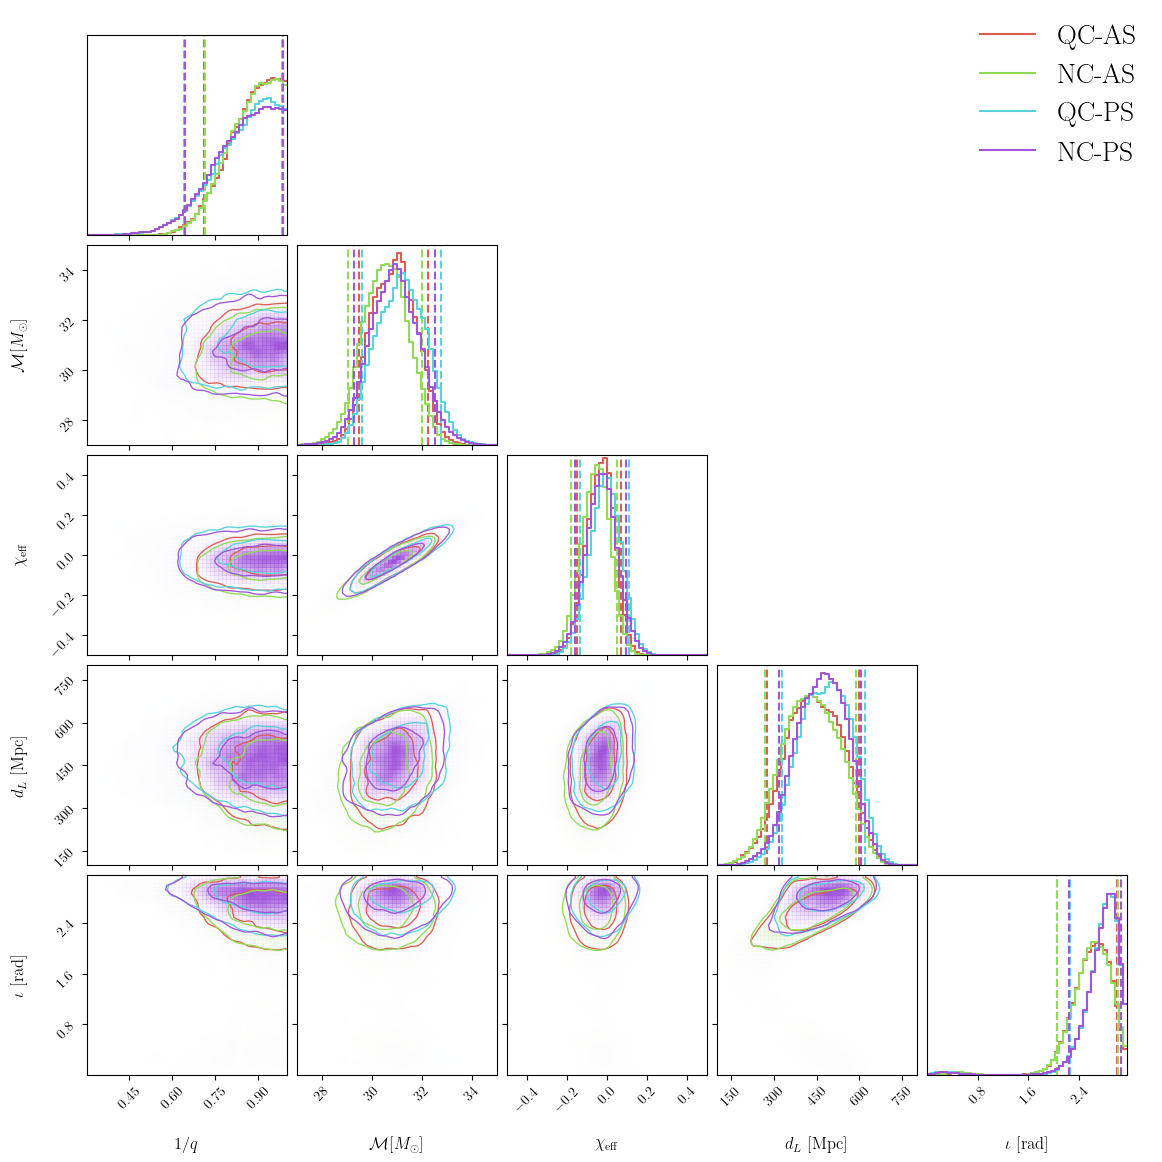

In [3]:

keys    = ['mass_ratio', 'chirp_mass', 'chi_eff', 'luminosity_distance', 'iota']
ranges  = [[0.3, 1], [27, 35], [-0.5, 0.5], [100, 800], [0, np.pi]]
ylimits = [8, None, None, 6, None]

fig = None
for name in names_all:
    col = color_dict[name]
    data_file = data_dict[name]
    data = Posterior(data_file)
    fig, ax = data.make_corner_plot(keys,  limits=ranges, ylimits=ylimits, color=col, fig=fig, bin=50, lbl=None)

fig.legend(handles=[mlines.Line2D([], [], color=c, label=l) for c, l in zip(colors_all, ['QC-AS', 'NC-AS', 'QC-PS', 'NC-PS'])]
            ,fontsize=20, frameon=False, loc="upper right")
plt.show()

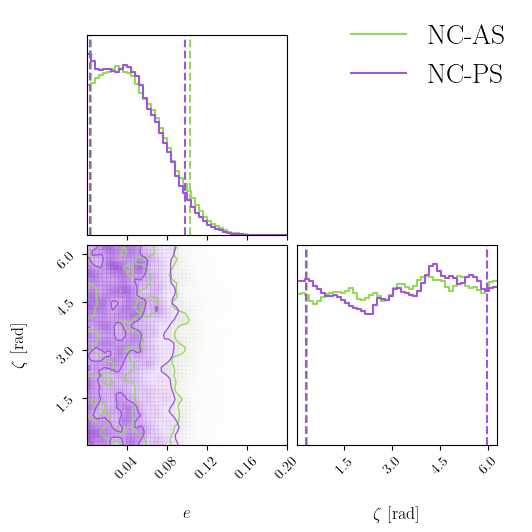

In [4]:
# eccentricity and anomaly
keys    = ['eccentricity',  'mean_per_ano']
ranges = [[0., 0.2], [0., 2*np.pi]]

these_colors = []
these_labels = []
fig = None
for name in ['teob_ecc', 'teob_prc_ecc']:
    col = color_dict[name]
    data_file = data_dict[name]
    data = Posterior(data_file)
    fig, ax = data.make_corner_plot(keys,  limits=ranges, color=col, fig=fig, bin=50, lbl=None)
    these_colors.append(col)
    these_labels.append(legend_labels[name])

fig.legend(handles=[mlines.Line2D([], [], color=c, label=l) for c, l in zip(these_colors, these_labels)]
            ,fontsize=20, frameon=False, loc="upper right")
plt.show()

## Waveform reconstruction

In [5]:
import bilby;
from gwpy.timeseries import TimeSeries

def get_whitened_time_series_from_whitened_frequency_series(ifo, whitened_fd_waveform):
    """
    Get the whitened time series from the whitened frequency series.
    """
    # get the whitened time series
    frequency_window_factor = (
        np.sum(ifo.frequency_mask)
        / len(ifo.frequency_mask)
    )
    whitened_time_series = (
        np.fft.irfft(whitened_fd_waveform)
        * np.sqrt(np.sum(ifo.frequency_mask)) / frequency_window_factor
    )
    return whitened_time_series

/home/rox/miniconda3/envs/pyart-dev-3.11/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [6]:
# detector parameters
trigger_time          = 1126259462.391
detectors             = ["H1", "L1"]
maximum_frequency     = 896.0
minimum_frequency     = 20.0
roll_off              = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
duration              = 8  # Analysis segment duration
post_trigger_duration = 2  # Time between trigger time and end of segment
end_time   = trigger_time + post_trigger_duration
start_time = end_time - duration

frequency_array = np.arange(0., 2048.0+1./8, 1./8)

In [7]:
# We now use gwpy to obtain analysis and psd data and create the ifo_list
ifo_list = bilby.gw.detector.InterferometerList([])
for det in detectors:
    ifo  = bilby.gw.detector.get_empty_interferometer(det)
    data = TimeSeries.fetch_open_data(ifo=det, start=1126259456.391, end=1126259464.391, )
    ifo.strain_data.set_from_gwpy_timeseries(data)

    # PSD
    freq, psdv = np.loadtxt(f'./psds/GWTC1_GW150914_PSDs_{det}.dat', unpack=True)
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=freq, psd_array=psdv
    )
    ifo.maximum_frequency = maximum_frequency
    ifo.minimum_frequency = minimum_frequency
    
    # get the whitened time domain strain
    whitened_fd = ifo.whitened_frequency_domain_strain
    ifo._whitened_time_domain_strain = get_whitened_time_series_from_whitened_frequency_series(ifo, whitened_fd)
    ifo_list.append(ifo)

# load the pre-computed waveform CIs
n_times = int((end_time - start_time )*4096.) - 1
cis = {ifo.name: np.empty((2, n_times)) for ifo in ifo_list}
for ifo in ifo_list:
    cis[ifo.name] = np.load(f'./wf_rec/CIs_{ifo.name}.npy')

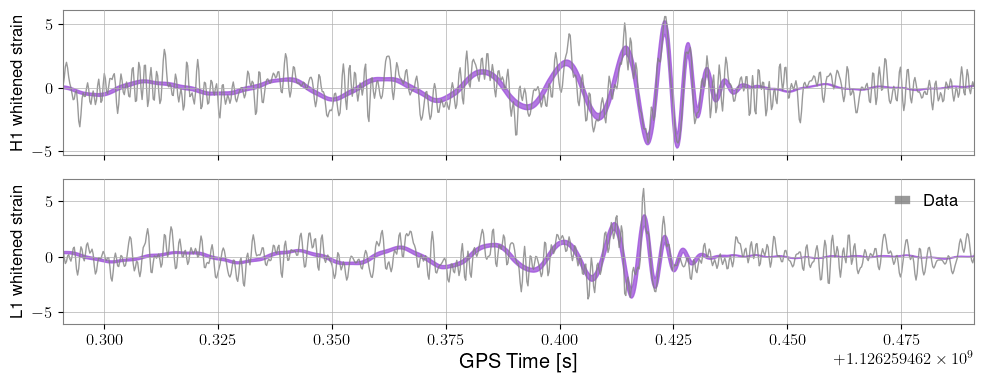

In [8]:
fig, ax = plt.subplots(len(detectors), 1, figsize=(10, 4), sharex=True)

for ifo, tax in zip(ifo_list, ax):
    time_idxs = (
            (ifo.time_array >= start_time) &
            (ifo.time_array <= end_time)
        )
    frequency_idxs = np.where(ifo.frequency_mask)[0]
    tax.plot(ifo.time_array[time_idxs], ifo.whitened_time_domain_strain[time_idxs], color='gray', lw=1., alpha=0.8, label=f'Data')

    tax.fill_between(ifo.time_array[time_idxs], 
                cis[ifo.name][0], 
                cis[ifo.name][1],
                alpha=.8,
                color=colors_all[-1],
                )
        
    tax.set_ylabel(f'{ifo.name} whitened strain', fontsize=12)
tax.legend(loc='upper right', frameon=False)
tax.set_xlim(trigger_time-0.1, trigger_time+0.1)
tax.set_ylim(-6, 7)
tax.set_xlabel('GPS Time [s]')
plt.tight_layout()